     user_id     attrition_flag  customer_age gender  dependent_count  \
0  768805383  Existing Customer            45      M                3   
1  818770008  Existing Customer            49      F                5   
2  713982108  Existing Customer            51      M                3   
3  769911858  Existing Customer            40      F                4   
4  709106358  Existing Customer            40      M                3   

  education_level marital_status income_category card_category  \
0     High School        Married     $60K - $80K          Blue   
1        Graduate         Single  Less than $40K          Blue   
2        Graduate        Married    $80K - $120K          Blue   
3     High School        Unknown  Less than $40K          Blue   
4      Uneducated        Married     $60K - $80K          Blue   

   months_on_book  ...  contacts_count_12_mon  credit_limit  \
0              39  ...                      3       12691.0   
1              44  ...                

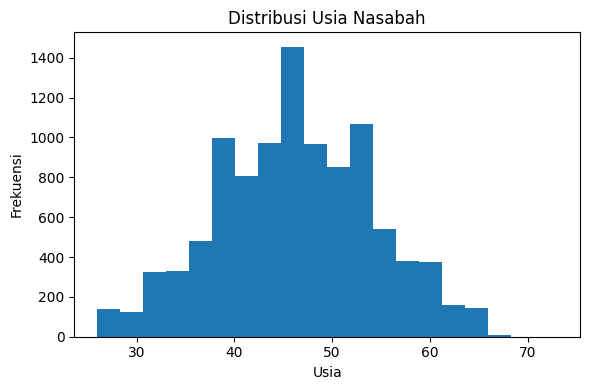

,age_bin,churn_rate
0,25-34,0.137415
1,35-44,0.159302
2,45-54,0.164901
3,55-64,0.167445
4,65-74,0.099099


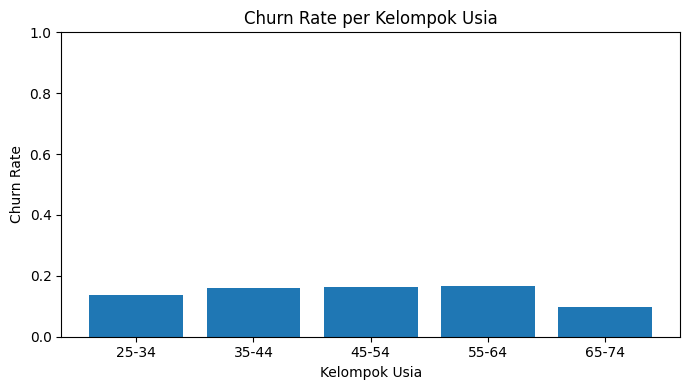

Kelompok usia dengan churn rate tertinggi:
  age_bin  churn_rate
3   55-64    0.167445
=== Metrics Comparison ===
                      Model  Accuracy  Precision  Recall      F1  ROC AUC  \
0  Baseline (Most Frequent)    0.8396     0.0000  0.0000  0.0000   0.5000   
1       Logistic Regression    0.9033     0.7768  0.5569  0.6487   0.9169   

   PR AUC  
0  0.1604  
1  0.7410  

=== Classification Report (Logistic Regression) ===
              precision    recall  f1-score   support

           0     0.9197    0.9694    0.9439      1701
           1     0.7768    0.5569    0.6487       325

    accuracy                         0.9033      2026
   macro avg     0.8483    0.7632    0.7963      2026
weighted avg     0.8968    0.9033    0.8966      2026



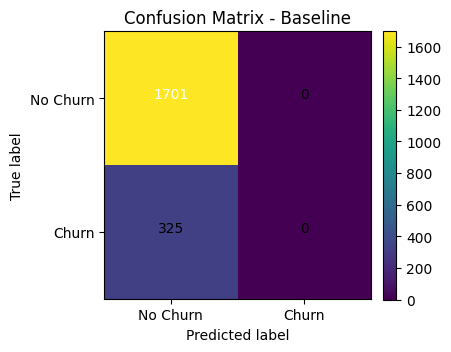

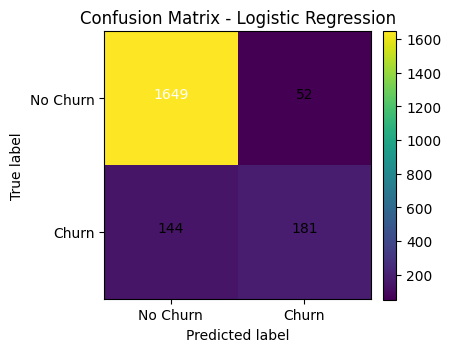

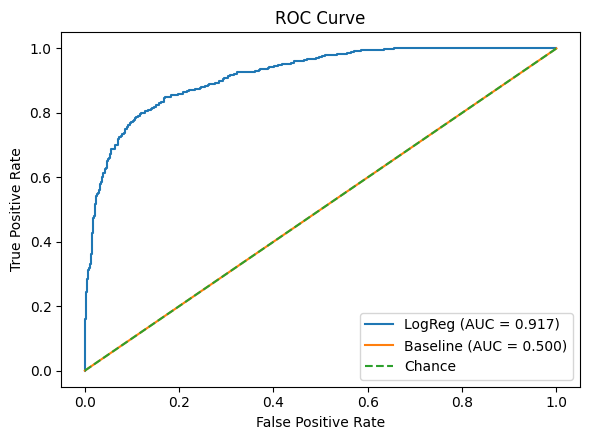

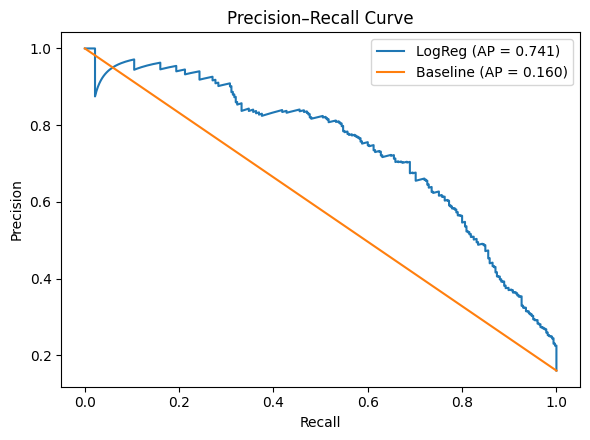

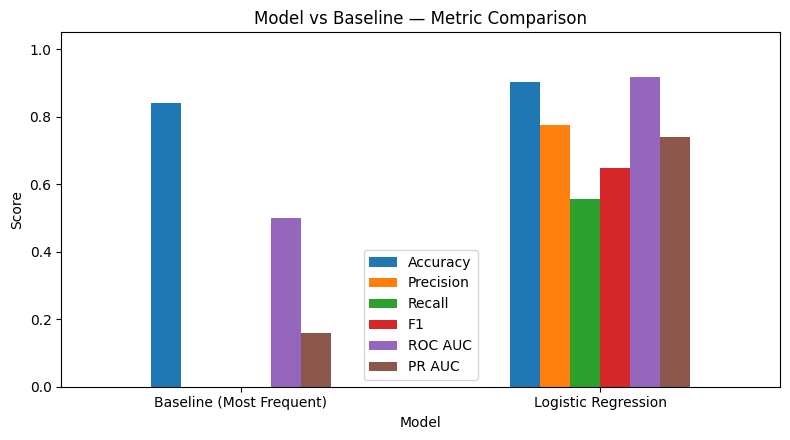


=== Top 15 Koefisien (|pengaruh| terbesar terhadap churn) ===
            feature_transformed      coef  abs_coef
12               total_trans_ct -2.762670  2.762670
11              total_trans_amt  1.559128  1.559128
42                age_bin_65-74 -1.258958  1.258958
16                     gender_M -0.822290  0.822290
34           card_category_Blue -0.819764  0.819764
4      total_relationship_count -0.749331  0.749331
8           total_revolving_bal -0.719136  0.719136
13          total_ct_chng_q4_q1 -0.682169  0.682169
25       marital_status_Married -0.602354  0.602354
6         contacts_count_12_mon  0.588887  0.588887
41                age_bin_55-64 -0.587383  0.587383
5        months_inactive_12_mon  0.521543  0.521543
37         card_category_Silver -0.423506  0.423506
39                age_bin_35-44  0.409491  0.409491
29  income_category_$40K - $60K -0.391683  0.391683


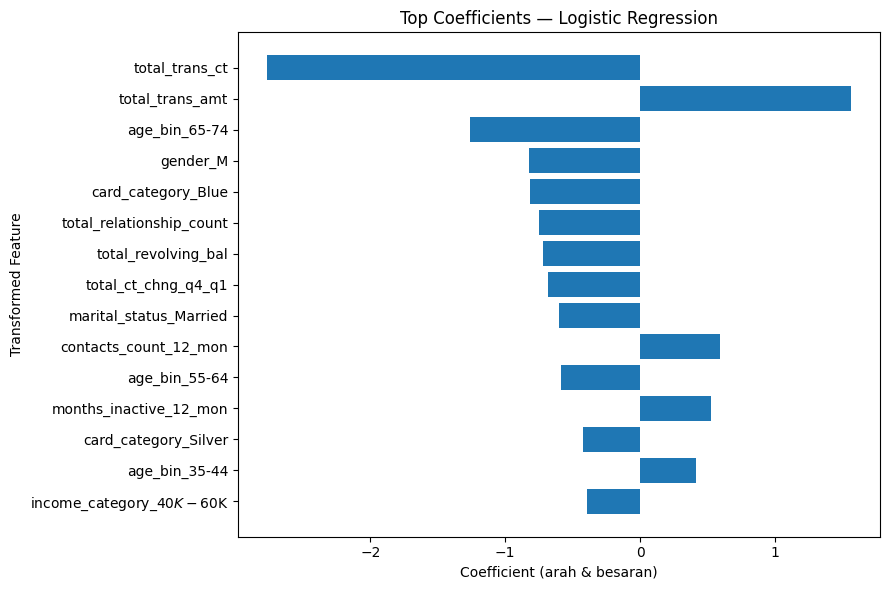


=== Top 15 Permutation Feature Importance (ROC AUC) ===
            feature_transformed  importance_mean  importance_std
12               total_trans_ct         0.314012        0.013332
11              total_trans_amt         0.059055        0.003435
8           total_revolving_bal         0.025001        0.004370
13          total_ct_chng_q4_q1         0.023067        0.003554
6         contacts_count_12_mon         0.018254        0.003982
4      total_relationship_count         0.015869        0.003214
5        months_inactive_12_mon         0.012290        0.002167
16                     gender_M         0.007215        0.002044
25       marital_status_Married         0.004115        0.001222
1                  customer_age         0.002791        0.001209
0                       user_id         0.001942        0.000635
34           card_category_Blue         0.001885        0.000907
29  income_category_$40K - $60K         0.001677        0.000535
38                age_bin_25-34  

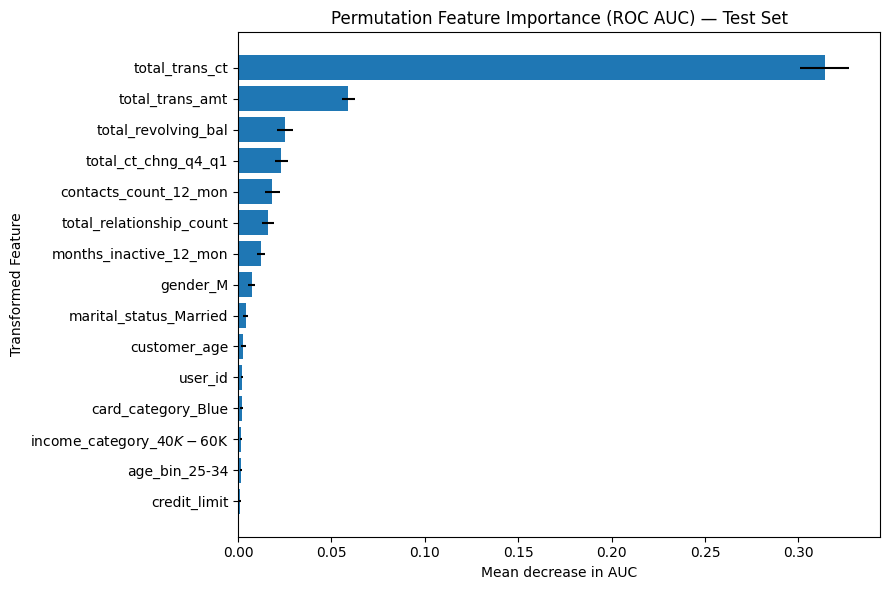

In [ ]:
# =========================================================
# Bank Churn — EDA + Modeling + Evaluation (CRISP-DM Ready)
# =========================================================

# 0) IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency  # optional (tak wajib dipakai)

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc,
    precision_recall_curve, average_precision_score,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import itertools
import warnings
warnings.filterwarnings("ignore")

# 1) LOAD DATA
# Ubah path bila perlu: di Colab biasanya "/content/xxx.csv"
df = pd.read_csv("/content/bank_churn_data.csv")

# 2) TARGET: churn (1 = attrited), cek kolom wajib
assert 'attrition_flag' in df.columns, "Kolom 'attrition_flag' tidak ada."
df['churn'] = df['attrition_flag'].astype(str).str.lower().str.contains('attrited').astype(int)

print(df.head())
print(df['attrition_flag'].value_counts(dropna=False))
print(round(df['churn'].mean(), 4), ' <- churn rate keseluruhan')

# =========================================================
# 3) EDA — DISTRIBUSI USIA & KELOMPOK USIA DENGAN CHURN TERBESAR
# =========================================================

# a) Histogram distribusi usia
if 'customer_age' in df.columns:
    plt.figure(figsize=(6,4))
    plt.hist(df['customer_age'].dropna(), bins=20)
    plt.title('Distribusi Usia Nasabah')
    plt.xlabel('Usia')
    plt.ylabel('Frekuensi')
    plt.tight_layout()
    plt.show()

    # b) Binning usia (atur sesuai kebutuhan)
    age_bins  = [18, 25, 35, 45, 55, 65, 75, 100]
    age_lbls  = ['18-24','25-34','35-44','45-54','55-64','65-74','75+']
    df['age_bin'] = pd.cut(df['customer_age'], bins=age_bins, labels=age_lbls, right=False)

    # c) Churn rate per kelompok usia
    age_churn = (df
        .groupby('age_bin', observed=True)['churn']
        .mean()
        .reset_index()
        .rename(columns={'churn':'churn_rate'}))

    try:
        # display() kalau di notebook; kalau tidak ada, pakai print
        display(age_churn)
    except NameError:
        print(age_churn)

    # d) Visualisasi churn rate per kelompok usia
    plt.figure(figsize=(7,4))
    plt.bar(age_churn['age_bin'].astype(str), age_churn['churn_rate'])
    plt.title('Churn Rate per Kelompok Usia')
    plt.xlabel('Kelompok Usia')
    plt.ylabel('Churn Rate')
    plt.xticks(rotation=0)
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    # e) Kelompok usia tertinggi churn
    top_age = age_churn.sort_values('churn_rate', ascending=False).head(1)
    print('Kelompok usia dengan churn rate tertinggi:')
    print(top_age)
else:
    print("Kolom 'customer_age' tidak ditemukan; lewati analisis usia.")

# =========================================================
# 4) PERSIAPAN FITUR & SPLIT DATA
# =========================================================

# Tentukan kolom yang tidak boleh jadi fitur
drop_cols = {'churn', 'attrition_flag'}  # target dan indikatornya
# Tambah kolom id unik kalau ada
for c in ['customer_id', 'CLIENTNUM', 'id']:
    if c in df.columns:
        drop_cols.add(c)

# Tentukan fitur X dan target y
feature_cols = [c for c in df.columns if c not in drop_cols]
X = df[feature_cols].copy()
y = df['churn'].copy()

# Bagi numeric vs categorical
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

# Train-test split (stratify agar proporsi churn terjaga)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================================================
# 5) PREPROCESSING & MODEL
# =========================================================

# Preprocessor: scale numerik, one-hot untuk kategorikal
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ],
    remainder="drop"
)

# Model: Logistic Regression (bisa diganti model lain)
log_reg = LogisticRegression(max_iter=1000, n_jobs=None)

# Pipeline: preprocessing -> model
clf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", log_reg)
])

# Fit
clf.fit(X_train, y_train)

# =========================================================
# 6) BASELINE & PREDIKSI
# =========================================================

baseline = DummyClassifier(strategy="most_frequent")
baseline.fit(X_train, y_train)

# Prediksi & skor
y_pred_m = clf.predict(X_test)
y_score_m = clf.predict_proba(X_test)[:, 1]

y_pred_b = baseline.predict(X_test)
# Skor probabilitas baseline pakai prevalensi kelas positif di train (konstan)
y_score_b = np.full(shape=y_test.shape, fill_value=y_train.mean(), dtype=float)

# =========================================================
# 7) EVALUASI
# =========================================================

def compute_metrics(y_true, y_pred, y_score):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_score),
        "PR AUC": average_precision_score(y_true, y_score)
    }

m_baseline = compute_metrics(y_test, y_pred_b, y_score_b)
m_model    = compute_metrics(y_test, y_pred_m, y_score_m)

eval_df = pd.DataFrame([
    {"Model":"Baseline (Most Frequent)", **m_baseline},
    {"Model":"Logistic Regression", **m_model}
])
print("=== Metrics Comparison ===")
print(eval_df.round(4))

print("\n=== Classification Report (Logistic Regression) ===")
print(classification_report(y_test, y_pred_m, digits=4))

# ---- Confusion Matrix plotter ----
def plot_cm(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(4.5,4))
    im = ax.imshow(cm, interpolation='nearest')
    ax.set_title(title)
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['No Churn','Churn'])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(['No Churn','Churn'])
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center",
                color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.show()
    return cm

_ = plot_cm(y_test, y_pred_b, title="Confusion Matrix - Baseline")
_ = plot_cm(y_test, y_pred_m, title="Confusion Matrix - Logistic Regression")

# ---- ROC Curves ----
fpr_m, tpr_m, _ = roc_curve(y_test, y_score_m)
fpr_b, tpr_b, _ = roc_curve(y_test, y_score_b)
auc_m = auc(fpr_m, tpr_m)
auc_b = auc(fpr_b, tpr_b)

plt.figure(figsize=(6,4.5))
plt.plot(fpr_m, tpr_m, label=f"LogReg (AUC = {auc_m:.3f})")
plt.plot(fpr_b, tpr_b, label=f"Baseline (AUC = {auc_b:.3f})")
plt.plot([0,1], [0,1], '--', label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ---- Precision–Recall Curves ----
prec_m, rec_m, _ = precision_recall_curve(y_test, y_score_m)
prec_b, rec_b, _ = precision_recall_curve(y_test, y_score_b)
ap_m = average_precision_score(y_test, y_score_m)
ap_b = average_precision_score(y_test, y_score_b)

plt.figure(figsize=(6,4.5))
plt.plot(rec_m, prec_m, label=f"LogReg (AP = {ap_m:.3f})")
plt.plot(rec_b, prec_b, label=f"Baseline (AP = {ap_b:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="upper right")
plt.tight_layout()
plt.show()

# ---- Bar chart: metric comparison ----
plot_cols = ["Accuracy","Precision","Recall","F1","ROC AUC","PR AUC"]
ax = eval_df.set_index("Model")[plot_cols].plot(kind="bar", figsize=(8,4.5))
plt.title("Model vs Baseline — Metric Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# =========================================================
# 8) INTERPRETASI MODEL
# =========================================================

# 8.1) Koefisien Logistic Regression (butuh nama fitur setelah transform)
# Ambil nama fitur transformasi:
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names_transformed = num_names + cat_names

# Ambil koefisien model
model = clf.named_steps['model']
coefs = model.coef_.ravel()

coef_df = (pd.DataFrame({
    'feature_transformed': feature_names_transformed,
    'coef': coefs,
    'abs_coef': np.abs(coefs)
})
.sort_values('abs_coef', ascending=False))

print("\n=== Top 15 Koefisien (|pengaruh| terbesar terhadap churn) ===")
print(coef_df.head(15))

# Visualisasi koefisien
top_n = 15
plt.figure(figsize=(9,6))
plt.barh(coef_df.head(top_n)['feature_transformed'][::-1],
         coef_df.head(top_n)['coef'][::-1])
plt.title('Top Coefficients — Logistic Regression')
plt.xlabel('Coefficient (arah & besaran)')
plt.ylabel('Transformed Feature')
plt.tight_layout()
plt.show()

# --- Siapkan nama fitur tertransform (num diikuti cat_OHE) ---
ohe = clf.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
num_names = num_cols
cat_names = ohe.get_feature_names_out(cat_cols).tolist()
feature_names_transformed = num_names + cat_names

# --- Transform X_test lalu hitung importance pada estimator akhir (bukan pipeline) ---
Xt_test = clf.named_steps['preprocessor'].transform(X_test)
final_est = clf.named_steps['model']

perm = permutation_importance(
    final_est, Xt_test, y_test,
    n_repeats=10, random_state=42, scoring='roc_auc'
)

# --- Bangun DataFrame dengan PANJANG yang cocok ---
perm_df = (pd.DataFrame({
    'feature_transformed': feature_names_transformed,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std
}).sort_values('importance_mean', ascending=False))

print("\n=== Top 15 Permutation Feature Importance (ROC AUC) ===")
print(perm_df.head(15))

# --- Plot ---
top_n = 15
plt.figure(figsize=(9,6))
plt.barh(perm_df.head(top_n)['feature_transformed'][::-1],
         perm_df.head(top_n)['importance_mean'][::-1],
         xerr=perm_df.head(top_n)['importance_std'][::-1])
plt.title('Permutation Feature Importance (ROC AUC) — Test Set')
plt.xlabel('Mean decrease in AUC')
plt.ylabel('Transformed Feature')
plt.tight_layout()
plt.show()
